In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import unicodedata
import re
import os

import time

In [2]:
import importlib
import src.models as model
importlib.reload(model)
import src.utils as util
importlib.reload(util);

In [3]:
# Global data
data_path = "data/fra.txt"
data_raw= pd.read_table(data_path,names=['source', 'target', 'comments'])
data_raw.sample(5)

sample_size=60000
source, target = util.create_dataset(data_path, sample_size)
print(source[-1])
print(target[-1])
type(target)


# en_sentence = u"May I borrow this book?"
# sp_sentence = u"¿Puedo tomar prestado este libro?"
# print(util.preprocess(en_sentence))
# print(util.preprocess(sp_sentence).encode('utf-8'))

start_ youve got paint on you . _end
start_ vous avez ,  sur vous ,  de la peinture . _end


tuple

In [4]:
# Create the source and target tokens and post pad them
source_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
source_tokenizer.fit_on_texts(source)
source_tensor = source_tokenizer.texts_to_sequences(source)
source_tensor= tf.keras.preprocessing.sequence.pad_sequences(source_tensor,padding='post')

target_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
target_tokenizer.fit_on_texts(target)
target_tensor = target_tokenizer.texts_to_sequences(target)
target_tensor= tf.keras.preprocessing.sequence.pad_sequences(target_tensor,padding='post')

print(target_tensor[0])
print(len(target_tensor[0]))
max_target_length= max(len(t) for t in  target_tensor)
print(max_target_length)
max_source_length= max(len(t) for t in  source_tensor)
print(max_source_length)

[ 1 99 15  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
18
18
11


In [5]:
# Creating training and validation sets using an 80-20 split
X_train, X_temp, y_train, y_temp = train_test_split(source_tensor, target_tensor, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# Show length
print(len(X_train), len(y_train), len(X_val), len(y_val))
type(X_train)

48000 48000 6000 6000


numpy.ndarray

In [6]:
print ("Input Language; index to word mapping")
util.convert(source_tokenizer, X_train[0])
print ()
print ("Target Language; index to word mapping")
util.convert(target_tokenizer, y_train[0])

Input Language; index to word mapping
1 ----> start_
4 ----> i
20 ----> was
57 ----> at
94 ----> home
3 ----> .
2 ----> _end

Target Language; index to word mapping
1 ----> start_
120 ----> jétais
149 ----> chez
55 ----> moi
3 ----> .
2 ----> _end


In [7]:
# Create a tf.data dataset
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 64
steps_per_epoch = len(X_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(source_tokenizer.word_index)+1
vocab_tar_size = len(target_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
type(dataset)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 11]), TensorShape([64, 18]))

In [8]:
# Encorder
encoder = model.Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 11, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [9]:
# Attention
attention_layer = model.BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 11, 1)


In [10]:
# Decoder
decoder = model.Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 15632)


In [11]:
# OptimizerCheckpoints (Object-based saving)
optimizer = tf.keras.optimizers.Adam()
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [12]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([target_tokenizer.word_index['start_']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += util.loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [34]:
# Training
print(steps_per_epoch)
EPOCHS = 5

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
      print('Epoch {} Batch {} loss {}'.format(epoch + 1,batch, batch_loss.numpy()))
   
      
  # saving (checkpoint) the model every 2 epochs
  if (epoch) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

750
Epoch 1 Batch 0 loss 0.08423732221126556
Epoch 1 Batch 100 loss 0.09745367616415024
Epoch 1 Batch 200 loss 0.07214236259460449
Epoch 1 Batch 300 loss 0.10590396821498871
Epoch 1 Batch 400 loss 0.08714687824249268
Epoch 1 Batch 500 loss 0.10341920703649521
Epoch 1 Batch 600 loss 0.07804811000823975
Epoch 1 Batch 700 loss 0.11810113489627838
Epoch 1 Loss 0.0864
Time taken for 1 epoch 1006.0658574104309 sec

Epoch 2 Batch 0 loss 0.06442483514547348
Epoch 2 Batch 100 loss 0.06493684649467468
Epoch 2 Batch 200 loss 0.08986983448266983
Epoch 2 Batch 300 loss 0.08731819689273834
Epoch 2 Batch 400 loss 0.09539923816919327
Epoch 2 Batch 500 loss 0.1028154268860817
Epoch 2 Batch 600 loss 0.1021396666765213
Epoch 2 Batch 700 loss 0.0941481962800026
Epoch 2 Loss 0.0849
Time taken for 1 epoch 992.0056018829346 sec

Epoch 3 Batch 0 loss 0.08786136656999588
Epoch 3 Batch 100 loss 0.06765250116586685
Epoch 3 Batch 200 loss 0.0681932270526886
Epoch 3 Batch 300 loss 0.07613656669855118
Epoch 3 Batch

In [13]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def evaluate(sentence):
  attention_plot = np.zeros((max_target_length, max_source_length))

  sentence = util.preprocess(sentence)
  #print(sentence)
  #print(source_sentence_tokenizer.word_index)

  inputs = [source_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_source_length,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_tokenizer.word_index['start_']], 0)

  for t in range(max_target_length):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += target_tokenizer.index_word[predicted_id] + ' '

    if target_tokenizer.index_word[predicted_id] == '_end':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot


def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: start_ i am going to work . _end
Predicted translation: je vais travailler . _end 


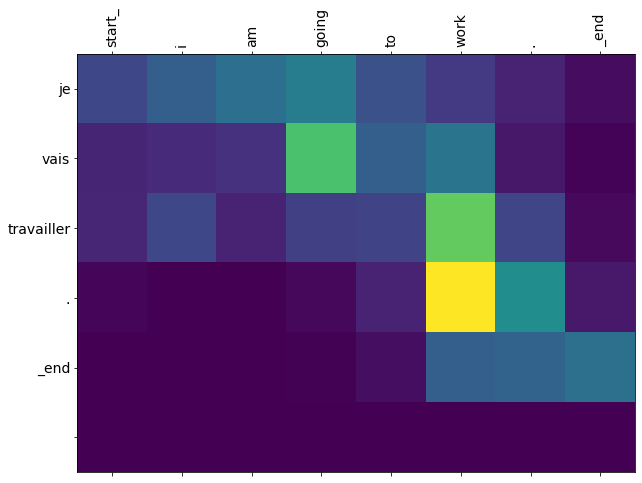

Input: start_ the project is super hard . _end
Predicted translation: le dictionnaire est agréable difficile . _end 


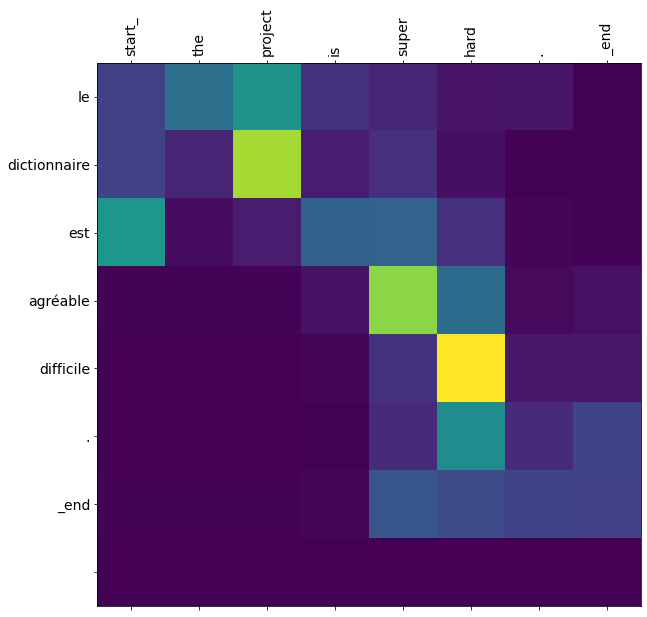

In [17]:
translate(u'I am going to work.')
translate(u'The project is super hard.')
# translate(u'she works', units, max_target_length, max_source_length, encoder, decoder, source_tokenizer, target_tokenizer)